In [1]:
import ray

In [2]:
if ray.is_initialized():
    ray.shutdown()
    
ray.init()

2024-08-17 06:31:17,056	INFO worker.py:1596 -- Connecting to existing Ray cluster at address: 192.168.68.63:6379...
2024-08-17 06:31:17,071	INFO worker.py:1772 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.18', ray_version='2.34.0', ray_commit='fc87217e031b4e551cbb3d3ffc75f8c0fb57886a')

In [3]:
dataset = ray.data.read_parquet(
    "s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2021.parquet"
)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ? file/s]

In [4]:
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.3)

2024-08-17 06:32:13,281	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:32:13,284	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet]


- ReadParquet->SplitBlocks(192) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

In [5]:
# Split datasets into blocks for parallel preprocessing.
# `num_blocks` should be lower than number of cores in the cluster.
train_dataset = train_dataset.repartition(num_blocks=3)
valid_dataset = valid_dataset.repartition(num_blocks=3)

In [6]:
print(f"Schema of training dataset: \n {train_dataset.schema()}")

2024-08-17 06:32:44,486	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:32:44,488	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> LimitOperator[limit=1]


- Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

- limit=1 3: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

Schema of training dataset: 
 Column             Type
------             ----
passenger_count    double
trip_distance      double
fare_amount        double
trip_duration      int64
hour               int64
day_of_week        int64
is_big_tip         bool
__index_level_0__  int64


In [7]:
print(f"Number of samples in training dataset: \n {train_dataset.count()}")
print(f"Number of samples in validation dataset: \n {valid_dataset.count()}")

2024-08-17 06:33:11,362	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:33:11,364	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition]


- Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

2024-08-17 06:33:30,035	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:33:30,037	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition]


Number of samples in training dataset: 
 1893433


- Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

Number of samples in validation dataset: 
 811472


In [8]:
from ray.data.preprocessors import MinMaxScaler


In [9]:
# Define a preprocessor to normalize the columns by their range.
preprocessor = MinMaxScaler(columns=["trip_distance", "trip_duration"])

In [10]:
from ray.data.preprocessors import *

sample_data = ray.data.read_parquet(
    "s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2021.parquet"
)

# create new preprocessor
sample_preprocessor = PowerTransformer(
    columns=["trip_distance", "trip_duration"], power=0.5
)

# apply the transformation
transformed_data = sample_preprocessor.fit_transform(sample_data)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ? file/s]

2024-08-17 06:34:22,598	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:34:22,600	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet]


- ReadParquet->SplitBlocks(192) 1: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

2024-08-17 06:35:32,297	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:35:32,299	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> TaskPoolMapOperator[PowerTransformer]


- ReadParquet->SplitBlocks(192) 1: 0 bundle [00:00, ? bundle/s]

- PowerTransformer 2: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

(PowerTransformer pid=45062, ip=192.168.68.58) /home/jegui/anaconda3/envs/ray/lib/python3.9/site-packages/ray/data/preprocessors/transformer.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[78.49844719 75.38216849 24.98147513 ... 44.86149806 31.82306905
(PowerTransformer pid=45062, ip=192.168.68.58)  61.21392252]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
(PowerTransformer pid=45062, ip=192.168.68.58)   df.loc[:, self.columns] = df.loc[:, self.columns].transform(
(PowerTransformer pid=47484, ip=192.168.68.54) /home/jegui/anaconda3/envs/ray/lib/python3.9/site-packages/ray/data/preprocessors/transformer.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84.83317338  66.38128399  28.06659276 ... 131.46160497  17.28730152
(PowerTransformer pid=47484, ip=192.168.68.54)  36.        ]' has dtype in

2024-08-17 06:36:16,466	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 06:36:16,469	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> TaskPoolMapOperator[PowerTransformer]


- ReadParquet->SplitBlocks(192) 1: 0 bundle [00:00, ? bundle/s]

- PowerTransformer 2: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

array([[<Axes: title={'center': 'trip_duration'}>]], dtype=object)

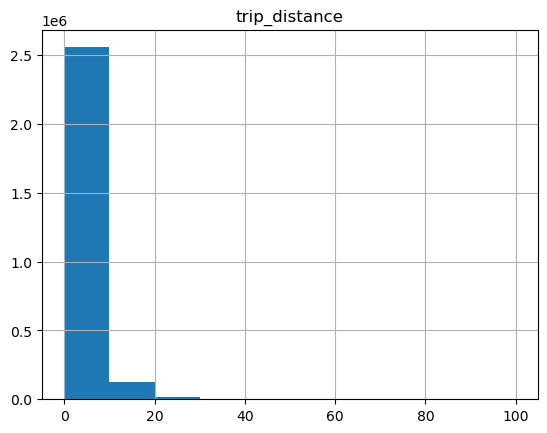

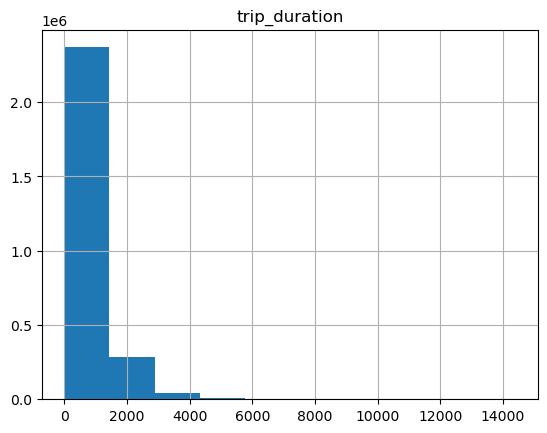

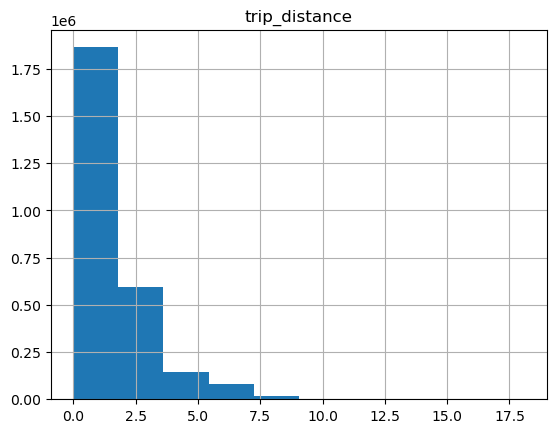

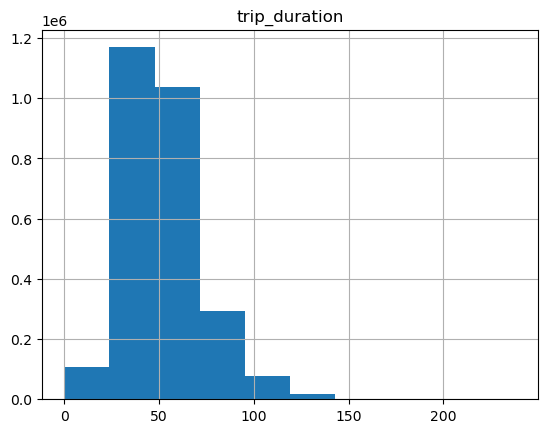

In [11]:
# Visualize original data.
sample_df = sample_data.to_pandas(limit=2704905)
sample_df.hist("trip_distance")
sample_df.hist("trip_duration")

# Visualize transformed data.
transformed_df = transformed_data.to_pandas(limit=2704905)
transformed_df.hist("trip_distance")
transformed_df.hist("trip_duration")

In [12]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

In [18]:
from ray import train
from ray.train import RunConfig

# Configure the shared filesystem path
shared_storage_path = "/mnt/shared/ray_results"

trainer = XGBoostTrainer(
    label_column="is_big_tip",
    run_config=RunConfig(storage_path=shared_storage_path),
    num_boost_round=50,
    scaling_config=ScalingConfig(
        num_workers=3,
        use_gpu=True,
        resources_per_worker={"CPU": 27, "GPU": 1}
    ),
    params={
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "tree_method": "approx",
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    # preprocessor=preprocessor,
)

In [22]:
result = trainer.fit()

2024-08-17 07:10:24,935	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-08-17 07:10:25 (running for 00:00:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-08-17_06-25-51_152386_177616/artifacts/2024-08-17_07-10-24/XGBoostTrainer_2024-08-17_06-53-53/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-08-17 07:10:30 (running for 00:00:05.24)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-08-17_06-25-51_152386_177616/artifacts/2024-08-17_07-10-24/XGBoostTrainer_2024-08-17_06-53-53/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(XGBoostTrainer pid=50338, ip=192.168.68.54) Started distributed worker processes: 
(XGBoostTrainer pid=50338, ip=192.168.68.54) - (node_id=b97182f155dc27f00aab31297f96df08c5ab5df4ef8f741c835acd09, ip=192.168.68.54, pid=50409) world_rank=0, local_rank=0, node_rank=0
(XGBoostTrainer pid=50338, ip=192.168.68.54) - (node_id=1ec9bfb415700b605ee400ae75b8c21786100aab29bc512483198af7, ip=192.168.68.58, pid=48521) world_rank=1, local_rank=0, node_rank=1
(XGBoostTrainer pid=50338, ip=192.168.68.54) - (node_id=8a424c7267359d93c8a7382bc2942f43d8df261cf264cb237d1d0ed4, ip=192.168.68.63, pid=185391) world_rank=2, local_rank=0, node_rank=2
(RayTrainWorker pid=50409, ip=192.168.68.54) [07:10:30] task [xgboost.ray-rank=00000000]:76508f8ce4732059071eb24c01000000 got new rank 0
(SplitCoordinator pid=50529, ip=192.168.68.54) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
(SplitCoordinator pid=50529, ip=192.168.68.54) Execution plan of Data

(pid=50529, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50529, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50529, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50529, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50530, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50530, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50530, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=50530, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

== Status ==
Current time: 2024-08-17 07:10:35 (running for 00:00:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-08-17_06-25-51_152386_177616/artifacts/2024-08-17_07-10-24/XGBoostTrainer_2024-08-17_06-53-53/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-08-17 07:10:40 (running for 00:00:15.34)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-08-17_06-25-51_152386_177616/artifacts/2024-08-17_07-10-24/XGBoostTrainer_2024-08-17_06-53-53/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2024-08-17 07:10:45 (running for 00:00:20.34)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 acce

(XGBoostTrainer pid=50338, ip=192.168.68.54) [0]	train-logloss:0.66887	train-error:0.39706	valid-logloss:0.66839	valid-error:0.39575
(XGBoostTrainer pid=50338, ip=192.168.68.54) [1]	train-logloss:0.66531	train-error:0.39402	valid-logloss:0.66505	valid-error:0.39278
(XGBoostTrainer pid=50338, ip=192.168.68.54) [2]	train-logloss:0.66340	train-error:0.39376	valid-logloss:0.66334	valid-error:0.39267
(XGBoostTrainer pid=50338, ip=192.168.68.54) [3]	train-logloss:0.66205	train-error:0.39290	valid-logloss:0.66216	valid-error:0.39198
(XGBoostTrainer pid=50338, ip=192.168.68.54) [4]	train-logloss:0.66126	train-error:0.39277	valid-logloss:0.66151	valid-error:0.39194
(XGBoostTrainer pid=50338, ip=192.168.68.54) [5]	train-logloss:0.66064	train-error:0.39239	valid-logloss:0.66100	valid-error:0.39172
(XGBoostTrainer pid=50338, ip=192.168.68.54) [6]	train-logloss:0.66024	train-error:0.39193	valid-logloss:0.66068	valid-error:0.39144
(XGBoostTrainer pid=50338, ip=192.168.68.54) [7]	train-logloss:0.6599

(RayTrainWorker pid=50409, ip=192.168.68.54) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_72a16_00000_0_2024-08-17_07-10-24/checkpoint_000000)
(RayTrainWorker pid=185391) [07:10:30] task [xgboost.ray-rank=00000002]:166fcef37e9dfdbb5e101e5701000000 got new rank 2 [repeated 2x across cluster]
(SplitCoordinator pid=50530, ip=192.168.68.54) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
(SplitCoordinator pid=50530, ip=192.168.68.54) Execution plan of Dataset: InputDataBuffer[Input] -> AllToAllOperator[Repartition] -> OutputSplitter[split(3, equal=True)]
(XGBoostTrainer pid=48740, ip=192.168.68.58) Started distributed worker processes: 
(XGBoostTrainer pid=48740, ip=192.168.68.58) - (node_id=1ec9bfb415700b605ee400ae75b8c21786100aab29bc512483198af7, ip=192.168.68.58, pid=48811) world_rank=0, local_rank=0, node_rank=0
(XGBoostTrai

2024-08-17 07:11:01,885	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53' in 0.0120s.
2024-08-17 07:11:01,890	INFO tune.py:1041 -- Total run time: 36.95 seconds (36.92 seconds for the tuning loop).


== Status ==
Current time: 2024-08-17 07:11:01 (running for 00:00:36.93)
Using FIFO scheduling algorithm.
Logical resource usage: 82.0/96 CPUs, 3.0/3 GPUs (0.0/2.0 accelerator_type:P4000, 0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2024-08-17_06-25-51_152386_177616/artifacts/2024-08-17_07-10-24/XGBoostTrainer_2024-08-17_06-53-53/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [24]:
print(f"Result metrics: \n {result.metrics} \n")

Result metrics: 
 OrderedDict([('train-logloss', 0.6562931172023878), ('train-error', 0.3867041435868835), ('valid-logloss', 0.6583331851662311), ('valid-error', 0.388550408517875), ('timestamp', 1723903860), ('checkpoint_dir_name', 'checkpoint_000000'), ('should_checkpoint', True), ('done', True), ('training_iteration', 51), ('trial_id', '72a16_00000'), ('date', '2024-08-17_07-11-00'), ('time_this_iter_s', 0.08971381187438965), ('time_total_s', 32.48031949996948), ('pid', 50338), ('hostname', 'jegui-workstation1'), ('node_ip', '192.168.68.54'), ('config', {}), ('time_since_restore', 32.48031949996948), ('iterations_since_restore', 51), ('experiment_tag', '0')]) 



In [26]:
print(f"Training accuracy: {1 - result.metrics['train-error']: .4f}")
print(f"Validation accuracy: {1 - result.metrics['valid-error']: .4f}")

Training accuracy:  0.6133
Validation accuracy:  0.6114


In [28]:
from ray import tune 
from ray.tune.tuner import Tuner, TuneConfig 

param_space = {
    "params": {
        "eta": tune.uniform(0.2, 0.4),
        "max_depth": tune.randint(1, 6),
        "min_child_weight": tune.uniform(0.8, 1.0),
    }
}

tuner = Tuner(
    trainer,
    param_space=param_space,
    tune_config=TuneConfig(num_samples=3, metric="train-logloss", mode="min"),
)

In [29]:
result_grid = tuner.fit()

(pid=48931, ip=192.168.68.58) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48931, ip=192.168.68.58) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48931, ip=192.168.68.58) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48931, ip=192.168.68.58) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48932, ip=192.168.68.58) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48932, ip=192.168.68.58) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48932, ip=192.168.68.58) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=48932, ip=192.168.68.58) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(XGBoostTrainer pid=48740, ip=192.168.68.58) [0]	train-logloss:0.66827	train-error:0.39681	valid-logloss:0.66788	valid-error:0.39560
(XGBoostTrainer pid=48740, ip=192.168.68.58) [1]	train-logloss:0.66509	train-error:0.39477	valid-logloss:0.66496	valid-error:0.39372
(XGBoostTrainer pid=48740, ip=192.168.68.58) [2]	train-logloss:0.66343	train-error:0.39451	valid-logloss:0.66349	valid-error:0.39338
(XGBoostTrainer pid=48740, ip=192.168.68.58) [3]	train-logloss:0.66248	train-error:0.39440	valid-logloss:0.66264	valid-error:0.39319
(XGBoostTrainer pid=48740, ip=192.168.68.58) [4]	train-logloss:0.66199	train-error:0.39444	valid-logloss:0.66223	valid-error:0.39329
(XGBoostTrainer pid=48740, ip=192.168.68.58) [5]	train-logloss:0.66146	train-error:0.39374	valid-logloss:0.66178	valid-error:0.39259
(XGBoostTrainer pid=48740, ip=192.168.68.58) [6]	train-logloss:0.66105	train-error:0.39313	valid-logloss:0.66142	valid-error:0.39239
(XGBoostTrainer pid=48740, ip=192.168.68.58) [7]	train-logloss:0.6607

(RayTrainWorker pid=48811, ip=192.168.68.58) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08/checkpoint_000000)
(XGBoostTrainer pid=50972, ip=192.168.68.54) Started distributed worker processes: 
(XGBoostTrainer pid=50972, ip=192.168.68.54) - (node_id=b97182f155dc27f00aab31297f96df08c5ab5df4ef8f741c835acd09, ip=192.168.68.54, pid=51042) world_rank=0, local_rank=0, node_rank=0
(XGBoostTrainer pid=50972, ip=192.168.68.54) - (node_id=1ec9bfb415700b605ee400ae75b8c21786100aab29bc512483198af7, ip=192.168.68.58, pid=49157) world_rank=1, local_rank=0, node_rank=1
(XGBoostTrainer pid=50972, ip=192.168.68.54) - (node_id=8a424c7267359d93c8a7382bc2942f43d8df261cf264cb237d1d0ed4, ip=192.168.68.63, pid=186115) world_rank=2, local_rank=0, node_rank=2
(RayTrainWorker pid=51042, ip=192.168.68.54) [07:25:59] task [xgboost.ray-ran

(pid=51162, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51162, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51162, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51162, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51163, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51163, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51163, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51163, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(XGBoostTrainer pid=50972, ip=192.168.68.54) [0]	train-logloss:0.67184	train-error:0.40590	valid-logloss:0.67122	valid-error:0.40362
(XGBoostTrainer pid=50972, ip=192.168.68.54) [1]	train-logloss:0.66994	train-error:0.40153	valid-logloss:0.66950	valid-error:0.40013
(XGBoostTrainer pid=50972, ip=192.168.68.54) [2]	train-logloss:0.66839	train-error:0.39686	valid-logloss:0.66810	valid-error:0.39569
(XGBoostTrainer pid=50972, ip=192.168.68.54) [3]	train-logloss:0.66726	train-error:0.39686	valid-logloss:0.66713	valid-error:0.39569
(XGBoostTrainer pid=50972, ip=192.168.68.54) [4]	train-logloss:0.66646	train-error:0.39686	valid-logloss:0.66644	valid-error:0.39569
(XGBoostTrainer pid=50972, ip=192.168.68.54) [5]	train-logloss:0.66577	train-error:0.39685	valid-logloss:0.66577	valid-error:0.39569
(XGBoostTrainer pid=50972, ip=192.168.68.54) [6]	train-logloss:0.66526	train-error:0.39685	valid-logloss:0.66532	valid-error:0.39568
(XGBoostTrainer pid=50972, ip=192.168.68.54) [7]	train-logloss:0.6649

(RayTrainWorker pid=51042, ip=192.168.68.54) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00001_1_eta=0.2393,max_depth=2,min_child_weight=0.9734_2024-08-17_07-25-08/checkpoint_000000)
(XGBoostTrainer pid=51388, ip=192.168.68.54) Started distributed worker processes: 
(XGBoostTrainer pid=51388, ip=192.168.68.54) - (node_id=b97182f155dc27f00aab31297f96df08c5ab5df4ef8f741c835acd09, ip=192.168.68.54, pid=51458) world_rank=0, local_rank=0, node_rank=0
(XGBoostTrainer pid=51388, ip=192.168.68.54) - (node_id=1ec9bfb415700b605ee400ae75b8c21786100aab29bc512483198af7, ip=192.168.68.58, pid=49350) world_rank=1, local_rank=0, node_rank=1
(XGBoostTrainer pid=51388, ip=192.168.68.54) - (node_id=8a424c7267359d93c8a7382bc2942f43d8df261cf264cb237d1d0ed4, ip=192.168.68.63, pid=186349) world_rank=2, local_rank=0, node_rank=2
(RayTrainWorker pid=51458, ip=192.168.68.54) [07:27:30] task [xgboost.ray-ran

(pid=51578, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51578, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51578, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51578, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51579, ip=192.168.68.54) - Repartition 1:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51579, ip=192.168.68.54) Split Repartition 2:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51579, ip=192.168.68.54) - split(3, equal=True) 3:   0%|          | 0/3 [00:00<?, ? bundle/s]

(pid=51579, ip=192.168.68.54) Running 0:   0%|          | 0/3 [00:00<?, ? bundle/s]

(XGBoostTrainer pid=51388, ip=192.168.68.54) [0]	train-logloss:0.67125	train-error:0.40278	valid-logloss:0.67071	valid-error:0.40127
(XGBoostTrainer pid=51388, ip=192.168.68.54) [1]	train-logloss:0.66875	train-error:0.39748	valid-logloss:0.66838	valid-error:0.39618
(XGBoostTrainer pid=51388, ip=192.168.68.54) [2]	train-logloss:0.66691	train-error:0.39691	valid-logloss:0.66669	valid-error:0.39574
(XGBoostTrainer pid=51388, ip=192.168.68.54) [3]	train-logloss:0.66565	train-error:0.39690	valid-logloss:0.66555	valid-error:0.39572
(XGBoostTrainer pid=51388, ip=192.168.68.54) [4]	train-logloss:0.66487	train-error:0.39553	valid-logloss:0.66483	valid-error:0.39444
(XGBoostTrainer pid=51388, ip=192.168.68.54) [5]	train-logloss:0.66423	train-error:0.39487	valid-logloss:0.66426	valid-error:0.39385
(XGBoostTrainer pid=51388, ip=192.168.68.54) [6]	train-logloss:0.66378	train-error:0.39512	valid-logloss:0.66388	valid-error:0.39405
(XGBoostTrainer pid=51388, ip=192.168.68.54) [7]	train-logloss:0.6634

(RayTrainWorker pid=51458, ip=192.168.68.54) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00002_2_eta=0.2265,max_depth=3,min_child_weight=0.9098_2024-08-17_07-25-08/checkpoint_000000)
(MapWorker(MapBatches(drop_columns)->MapBatches(Predictor)) pid=51937, ip=192.168.68.54) /home/jegui/anaconda3/envs/ray/lib/python3.9/site-packages/xgboost/data.py:1017: UserWarning: Unknown data type: <class 'dict'>, trying to convert it to csr_matrix
(MapWorker(MapBatches(drop_columns)->MapBatches(Predictor)) pid=51937, ip=192.168.68.54)   warnings.warn(
(MapWorker(MapBatches(drop_columns)->MapBatches(Predictor)) pid=51937, ip=192.168.68.54) /home/jegui/anaconda3/envs/ray/lib/python3.9/site-packages/xgboost/data.py:1017: UserWarning: Unknown data type: <class 'dict'>, trying to convert it to csr_matrix
(MapWorker(MapBatches(drop_columns)->MapBatches(Predictor)) pid=51937, ip=192.168.68.54)   warnings

2024-08-17 07:28:48,315	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53' in 0.0143s.
2024-08-17 07:28:48,332	INFO tune.py:1041 -- Total run time: 219.77 seconds (219.70 seconds for the tuning loop).


In [45]:
best_result = result_grid.get_best_result()
print(f"Best result: \n {best_result} \n")

Best result: 
 Result(
  metrics={'train-logloss': 0.658009386519491, 'train-error': 0.38905912649622487, 'valid-logloss': 0.6589427518985922, 'valid-error': 0.3890519674171566},
  path='/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08/checkpoint_000000)
) 



In [32]:
print(f"Training accuracy: {1 - best_result.metrics['train-error']: .4f}")
print(f"Validation accuracy: {1 - best_result.metrics['valid-error']: .4f}")

Training accuracy:  0.6109
Validation accuracy:  0.6109


In [46]:

checkpoint_path = best_result.path

print(f"Checkpoint path: {checkpoint_path}")

Checkpoint path: /mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08


In [47]:
test_dataset = ray.data.read_parquet(
    "s3://anonymous@anyscale-training-data/intro-to-ray-air/nyc_taxi_2022.parquet"
).drop_columns("is_big_tip")

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ? file/s]

In [64]:
import xgboost as xgb
import os
import numpy as np
import pandas as pd  # Import Pandas

class XGBoostPredictor:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = self.load_model()
        
    def load_model(self):
        model = xgb.Booster()
        model.load_model(self.model_path)
        return model
    
    def predict(self, batch):
        # Convert batch to a supported format if necessary
        if isinstance(batch, dict):
            batch = pd.DataFrame(batch)
        elif isinstance(batch, list):
            batch = np.array(batch)
        
        dmatrix = xgb.DMatrix(batch)
        predictions = self.model.predict(dmatrix)
        return {'predictions': predictions}  # Return a dictionary

class Predictor:
    def __init__(self, model_path):
        self.predictor = XGBoostPredictor(model_path)
    
    def __call__(self, batch):
        return self.predictor.predict(batch)
        
model_path = "/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08/checkpoint_000000/model.ubj"

# Verify the model path
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Define the ActorPoolStrategy for parallel computation
scale = ray.data.ActorPoolStrategy(size=2)

# Apply the prediction function to each batch using map_batches
predictions = test_dataset.map_batches(
    Predictor,
    compute=scale,
    fn_constructor_kwargs={"model_path": model_path}
)

predictions.show(5)

2024-08-17 08:38:24,788	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-08-17 08:38:24,808	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-17_06-25-51_152386_177616/logs/ray-data
2024-08-17 08:38:24,810	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> ActorPoolMapOperator[MapBatches(drop_columns)->MapBatches(Predictor)] -> LimitOperator[limit=5]


- ReadParquet->SplitBlocks(192) 1: 0 bundle [00:00, ? bundle/s]

- MapBatches(drop_columns)->MapBatches(Predictor) 2: 0 bundle [00:00, ? bundle/s]

- limit=5 3: 0 bundle [00:00, ? bundle/s]

Running 0: 0 bundle [00:00, ? bundle/s]

{'predictions': 0.5078760385513306}
{'predictions': 0.561191737651825}
{'predictions': 0.552953839302063}
{'predictions': 0.42931267619132996}
{'predictions': 0.6253081560134888}


In [78]:
from ray import serve 
import requests
import xgboost as xgb
import pandas as pd
import numpy as np

serve.start()  # Ensure Serve is started


class XGBoostPredictor:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = self.load_model()
        
    def load_model(self):
        model = xgb.Booster()
        model.load_model(self.model_path)
        return model
    
    def predict(self, batch):
        if isinstance(batch, dict):
            batch = pd.DataFrame([batch])
        elif isinstance(batch, list):
            batch = pd.DataFrame(batch)
        
        dmatrix = xgb.DMatrix(batch)
        predictions = self.model.predict(dmatrix)
        return {'predictions': predictions.tolist()}

# Define the deployment
@serve.deployment(name="XGBoostService", num_replicas=2, route_prefix="/rayair")

@serve.ingress
class XGBoostService:
    def __init__(self, model_path):
        self.predictor = XGBoostPredictor(model_path)
    
    async def __call__(self, request):
        data = await request.json()
        predictions = self.predictor.predict(data)
        return predictions

model_path = "/mnt/shared/ray_results/XGBoostTrainer_2024-08-17_06-53-53/XGBoostTrainer_81519_00000_0_eta=0.3811,max_depth=4,min_child_weight=0.8570_2024-08-17_07-25-08/checkpoint_000000/model.ubj"

# Create an instance of the deployment
xgboost_service = XGBoostService.bind(model_path)

# Deploy the service
serve.run(xgboost_service)

# Send a request through HTTP
sample_input = test_dataset.take(1)
sample_input = dict(sample_input[0])

# Convert int64 values to int
for key, value in sample_input.items():
    if isinstance(value, np.int64):
        sample_input[key] = int(value)

response = requests.post("http://localhost:8000/rayair", json=[sample_input])

# Print the raw response content for debugging
print("Response content:", response.content)

# Attempt to decode the response as JSON
try:
    output = response.json()
    print(output)
except requests.exceptions.JSONDecodeError as e:
    print("Failed to decode JSON response:", e)

2024-08-17 09:06:08,851	WARNING api.py:346 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-08-17 09:06:08,853	WARNING api.py:390 -- DeprecationWarning: `route_prefix` in `@serve.deployment` has been deprecated. To specify a route prefix for an application, pass it into `serve.run` instead.
2024-08-17 09:06:08,855	WARNING api.py:397 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


ValueError: Class passed to @serve.ingress may not have __call__ method.